# Построение модели предсказания температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных**

`/datasets/final_steel/`

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

In [1]:
# importing libraries

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

from scipy import stats as st
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
# disabling warnings

warnings.filterwarnings('ignore')

In [3]:
# declaring constants

STATE = 171022
CV = 5

## Первичный анализ данных

### Обзор данных

In [5]:
# creating lists for parse_dates

bulk_time_list = [*range(1, 16)]
wire_time_list = [*range(1, 10)]

In [6]:
# loading data

try:
    data_arc = pd.read_csv('datasets/data_arc.csv',
                           index_col=[0], parse_dates=[1, 2])
    data_bulk = pd.read_csv('datasets/data_bulk.csv',
                            index_col=[0])
    data_bulk_time = pd.read_csv('datasets/data_bulk_time.csv',
                                 index_col=[0], parse_dates=bulk_time_list)
    data_gas = pd.read_csv('datasets/data_gas.csv',
                           index_col=[0])
    data_temp = pd.read_csv('datasets/data_temp.csv',
                            index_col=[0], parse_dates=[1])
    data_wire = pd.read_csv('datasets/data_wire.csv',
                            index_col=[0])
    data_wire_time = pd.read_csv('datasets/data_wire_time.csv',
                                 index_col=[0], parse_dates=wire_time_list)

except FileNotFoundError as e:
    print(repr(e))
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv',
                           index_col=[0], parse_dates=[1, 2])
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv',
                            index_col=[0])
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv',
                                 index_col=[0], parse_dates=bulk_time_list)
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv',
                           index_col=[0])
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv',
                            index_col=[0], parse_dates=[1])
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv',
                            index_col=[0])
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv',
                                 index_col=[0], parse_dates=wire_time_list)

#### data_arc

In [7]:
# getting general summary
data_arc.info()

# checking for correct output
display(data_arc.head())

# getting numerical summary
data_arc.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14876 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Начало нагрева дугой  14876 non-null  datetime64[ns]
 1   Конец нагрева дугой   14876 non-null  datetime64[ns]
 2   Активная мощность     14876 non-null  float64       
 3   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 581.1 KB


,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
key,,,,
1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,count,mean,std,min,25%,50%,75%,max
Активная мощность,14876.0,0.670441,0.408159,0.030002,0.395297,0.555517,0.857034,3.731596
Реактивная мощность,14876.0,0.452592,5.878702,-715.504924,0.290991,0.415962,0.637371,2.676388


In [8]:
# checking for explicit duplicates
print(f'Number of explicit duplicates: {data_arc.duplicated().sum()}')

Number of explicit duplicates: 0


In [9]:
data_arc.index.value_counts().head(10)

2108    16
1513    15
1689    15
2567    14
46      13
322     13
1829    12
44      12
2916    12
2917    11
Name: key, dtype: int64

In [10]:
data_arc.index.value_counts().count()

3214

<AxesSubplot:ylabel='Count'>

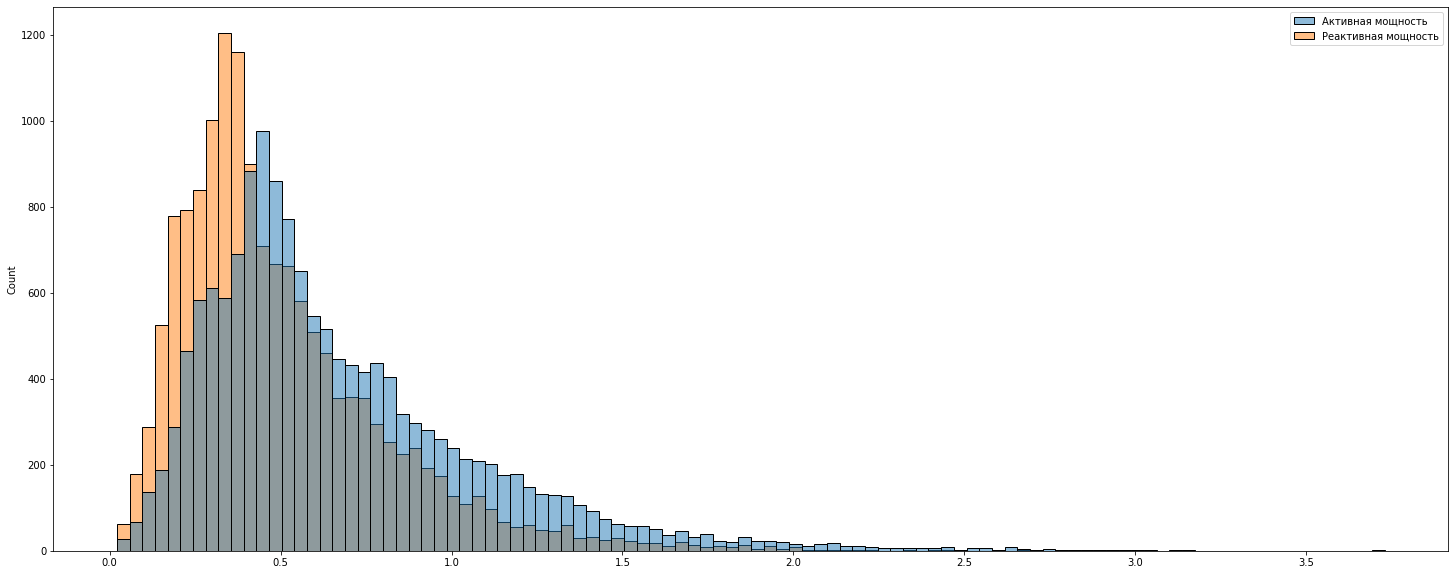

In [11]:
plt.figure(figsize=(25, 10))

sns.histplot(data_arc[data_arc['Реактивная мощность'] > 0], bins=100)

##### Вывод

- Данные об электродах представлены положительно смещенным нормальным распределением;
- Разные партии 'key' могут включать разное количество итераций работы электродов;
- Третий квартиль менее 1 для каждой мощности. Макссимальное значение больше 2. Без разъяснений технолога приму эти выбросы за потенциально возможные для восстановления температуры;


- Недостаток - названия столбцов на кириллице, простым текстом;
- Недостаток - имеется отрицательное значение Реактивной мощности;
- Недостаток - данные о времени записаны как строковые, требуется изменение типа данных.

#### data_bulk and data_bulk_time

In [12]:
data_bulk.info()
display(data_bulk.head())
data_bulk.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Bulk 1   252 non-null    float64
 1   Bulk 2   22 non-null     float64
 2   Bulk 3   1298 non-null   float64
 3   Bulk 4   1014 non-null   float64
 4   Bulk 5   77 non-null     float64
 5   Bulk 6   576 non-null    float64
 6   Bulk 7   25 non-null     float64
 7   Bulk 8   1 non-null      float64
 8   Bulk 9   19 non-null     float64
 9   Bulk 10  176 non-null    float64
 10  Bulk 11  177 non-null    float64
 11  Bulk 12  2450 non-null   float64
 12  Bulk 13  18 non-null     float64
 13  Bulk 14  2806 non-null   float64
 14  Bulk 15  2248 non-null   float64
dtypes: float64(15)
memory usage: 391.1 KB


,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,count,mean,std,min,25%,50%,75%,max
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0
Bulk 10,176.0,83.284091,26.060347,24.0,64.00,86.5,102.00,159.0


In [13]:
print(f'Number of explicit duplicates: {data_bulk.duplicated().sum()}')

Number of explicit duplicates: 80


In [14]:
data_bulk.index.value_counts().count()

3129

<AxesSubplot:ylabel='Count'>

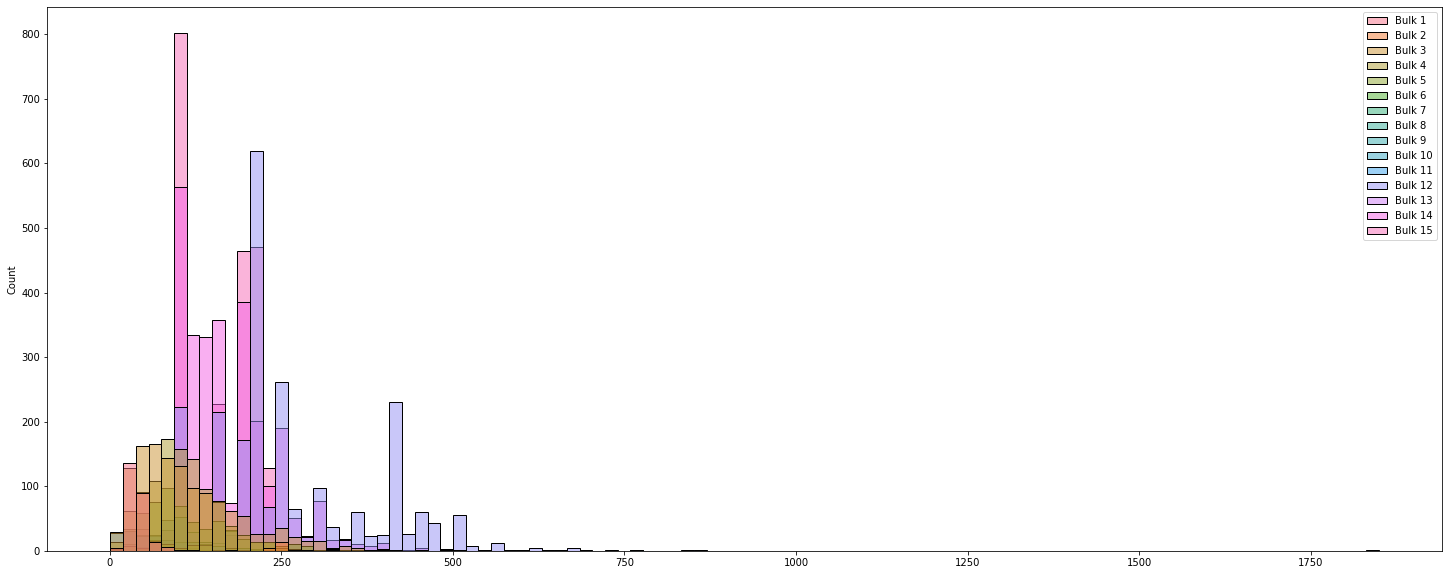

In [15]:
plt.figure(figsize=(25, 10))
sns.histplot(data_bulk, bins=100)

<AxesSubplot:xlabel='Bulk 12'>

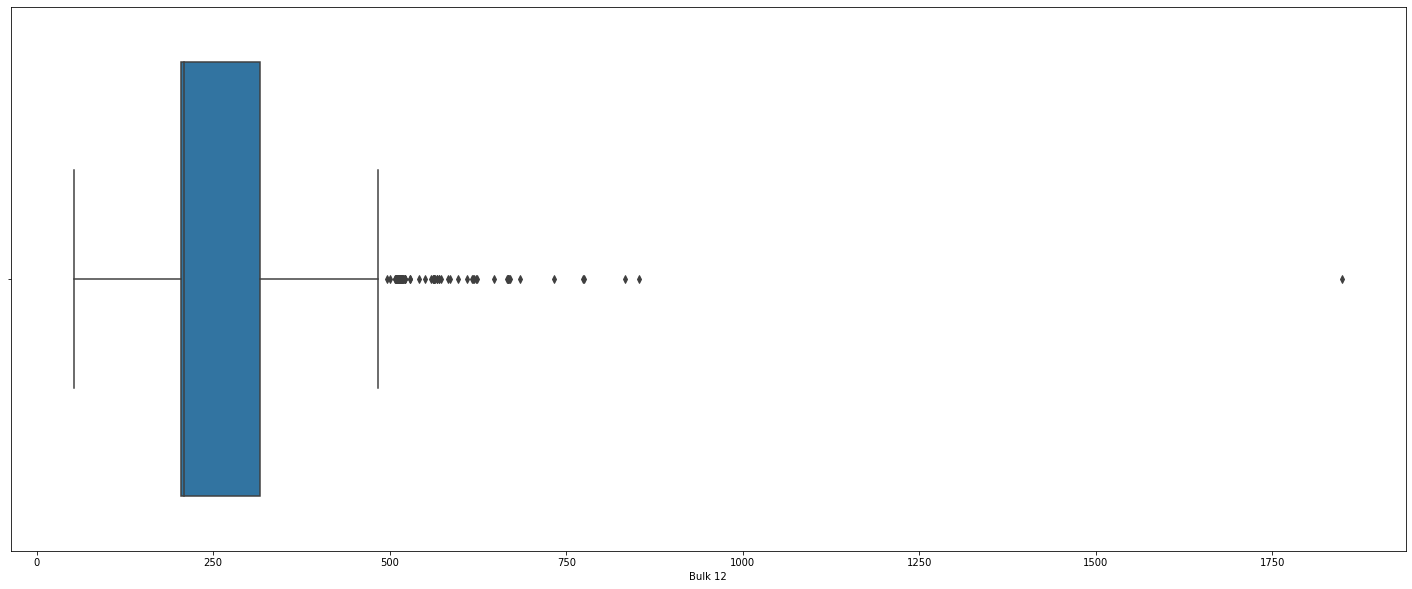

In [16]:
plt.figure(figsize=(25, 10))
sns.boxplot(data_bulk['Bulk 12'])

In [17]:
data_bulk_time.info()
display(data_bulk_time.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Bulk 1   252 non-null    datetime64[ns]
 1   Bulk 2   22 non-null     datetime64[ns]
 2   Bulk 3   1298 non-null   datetime64[ns]
 3   Bulk 4   1014 non-null   datetime64[ns]
 4   Bulk 5   77 non-null     datetime64[ns]
 5   Bulk 6   576 non-null    datetime64[ns]
 6   Bulk 7   25 non-null     datetime64[ns]
 7   Bulk 8   1 non-null      datetime64[ns]
 8   Bulk 9   19 non-null     datetime64[ns]
 9   Bulk 10  176 non-null    datetime64[ns]
 10  Bulk 11  177 non-null    datetime64[ns]
 11  Bulk 12  2450 non-null   datetime64[ns]
 12  Bulk 13  18 non-null     datetime64[ns]
 13  Bulk 14  2806 non-null   datetime64[ns]
 14  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15)
memory usage: 391.1 KB


,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56


In [18]:
print(f'Number of explicit duplicates: {data_bulk_time.duplicated().sum()}')

Number of explicit duplicates: 0


In [19]:
data_bulk_time.index.value_counts().count()

3129

##### Вывод

- Данные о добавлении примесей неоднородны;


- Недостаток - пропуски при отсутствии соответствующей колонке примеси в текущей партии;
- Недостаток - в колонке `Bulk 12` присутствует выброс значительно превосходящий остальные значения;
- Недостаток - названия столбцов простым текстом через пробел;
- Недостаток - колонки `Bulk` в датасете `data_bulk` содержат целочисленные данные, записаны как тип с плавающей запятой;
- Недостаток - данные о времени записаны как строковые, требуется изменение типа данных.

#### data_gas

In [20]:
data_gas.info()
display(data_gas.head())
data_gas.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Газ 1   3239 non-null   float64
dtypes: float64(1)
memory usage: 50.6 KB


,Газ 1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


,count,mean,std,min,25%,50%,75%,max
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


In [21]:
print(f'Number of explicit duplicates: {data_gas.duplicated().sum()}')

Number of explicit duplicates: 0


In [22]:
data_gas.index.value_counts().count()

3239

<AxesSubplot:ylabel='Count'>

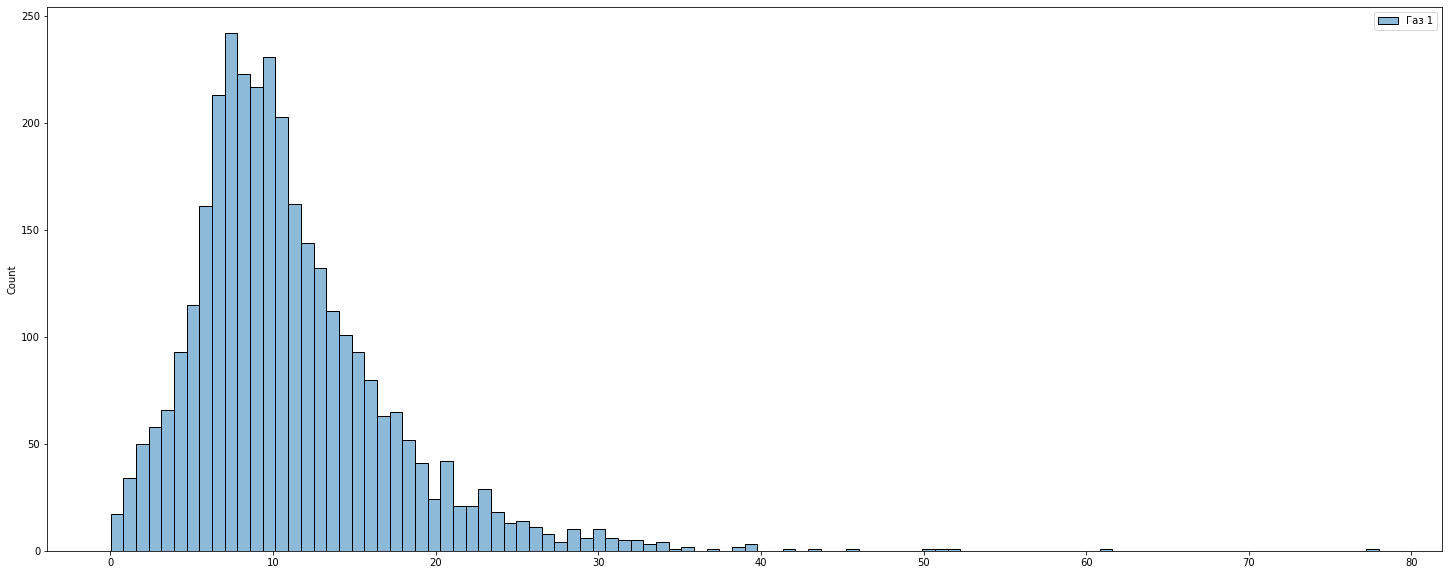

In [23]:
plt.figure(figsize=(25, 10))
sns.histplot(data_gas, bins=100)

<AxesSubplot:xlabel='Газ 1'>

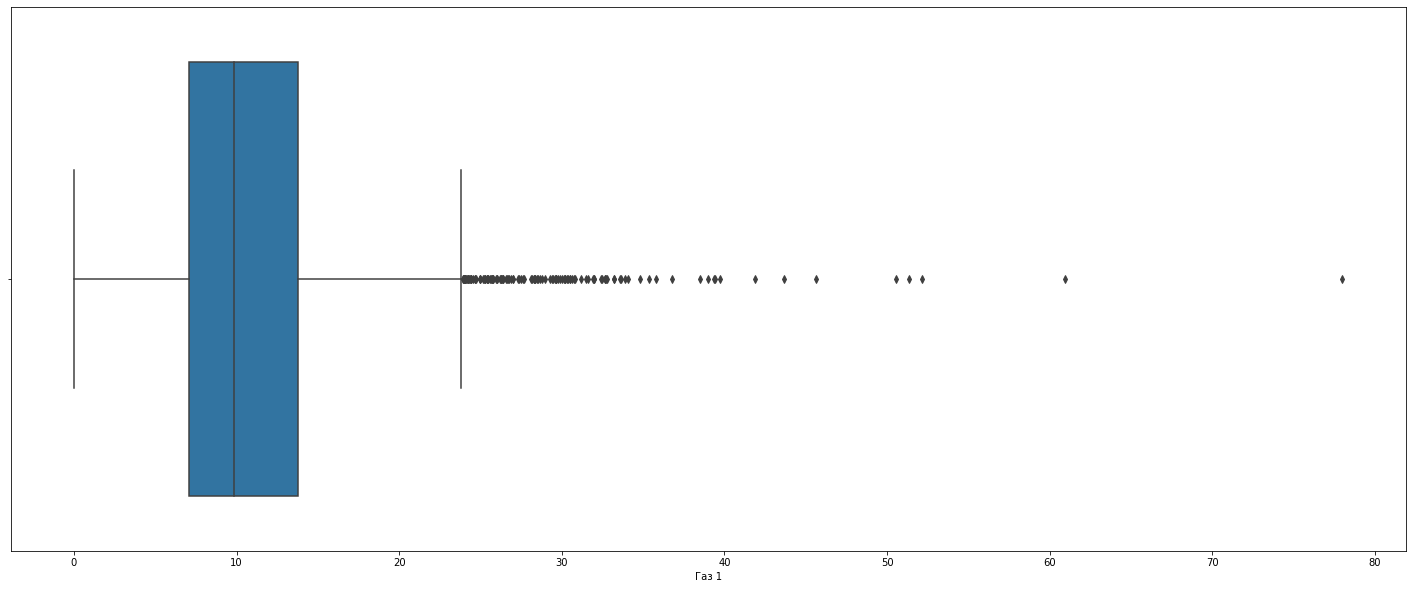

In [24]:
plt.figure(figsize=(25, 10))
sns.boxplot(data_gas['Газ 1'])

##### Вывод

- Данные об газовой продувке представлены положительно смещенным нормальным распределением;


- Недостаток - в колонке `Газ 1` присутствует выброс значительно превосходящий остальные значения;
- Недостаток - название столбца простым текстом через пробел.

#### data_temp

In [25]:
data_temp.info()
display(data_temp.head())
data_temp.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15907 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Время замера  15907 non-null  datetime64[ns]
 1   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 372.8 KB


,Время замера,Температура
key,,
1,2019-05-03 11:16:18,1571.0
1,2019-05-03 11:25:53,1604.0
1,2019-05-03 11:29:11,1618.0
1,2019-05-03 11:30:01,1601.0
1,2019-05-03 11:30:39,1613.0


,count,mean,std,min,25%,50%,75%,max
Температура,13006.0,1591.84092,21.375851,1191.0,1581.0,1591.0,1601.0,1705.0


In [26]:
print(f'Number of explicit duplicates: {data_temp.duplicated().sum()}')

Number of explicit duplicates: 0


In [27]:
data_temp.index.value_counts().count()

3216

<AxesSubplot:ylabel='Count'>

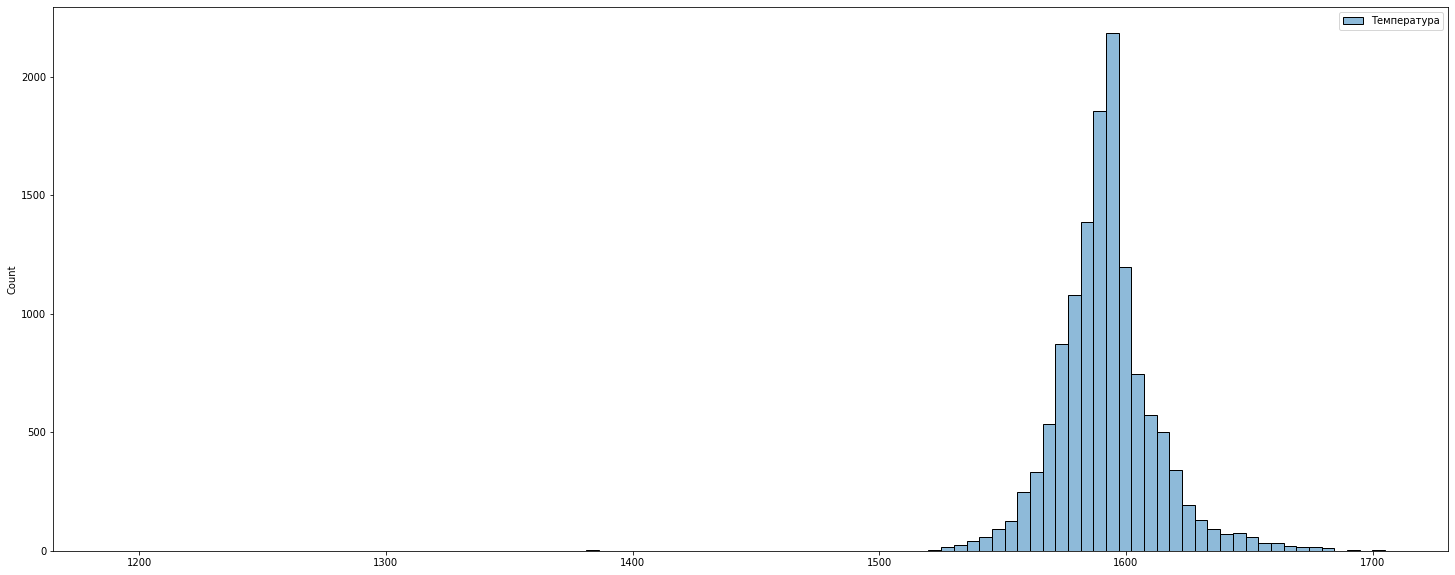

In [28]:
plt.figure(figsize=(25, 10))
sns.histplot(data_temp, bins=100)

<AxesSubplot:xlabel='Температура'>

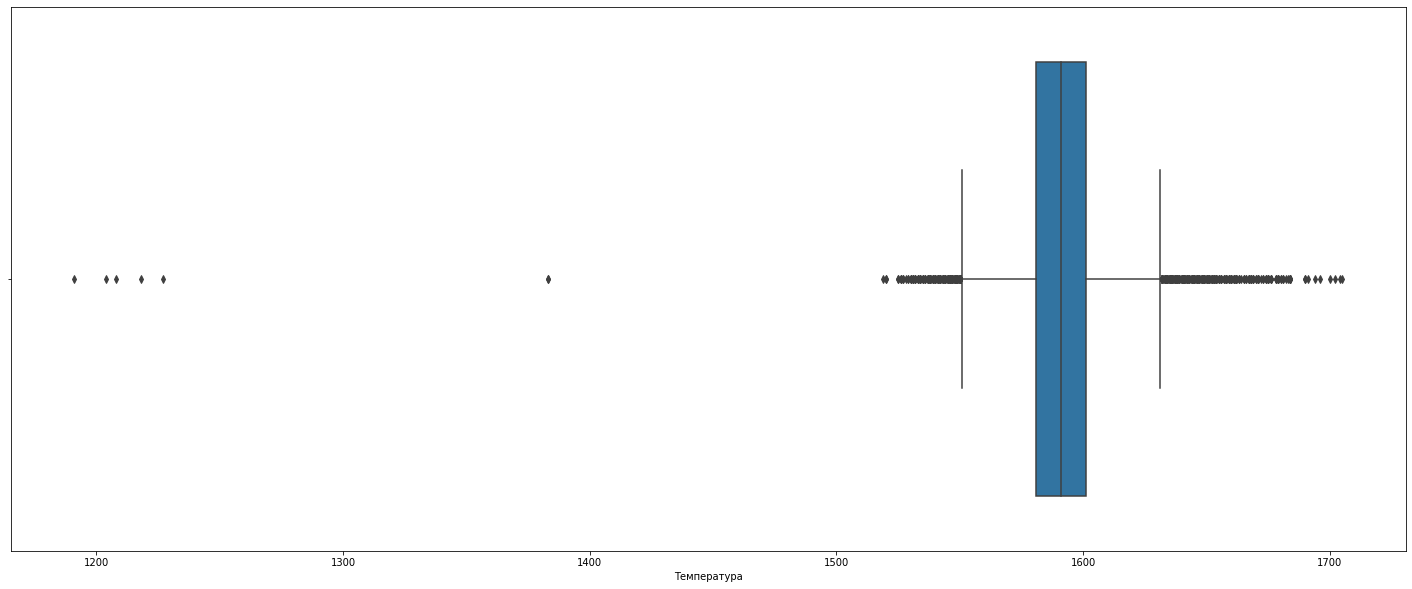

In [29]:
plt.figure(figsize=(25, 10))
sns.boxplot(data_temp['Температура'])

##### Вывод

- Данные о температуре представлены положительно смещенным нормальным распределением;


- Недостаток - названия столбцов на кириллице, простым текстом;
- Недостаток - пропуски в колонке `Температура`;
- Недостаток - в колонке `Температура` присутствует выброс значительно ниже остальных значений. Температура плавления железа 1539 градусов цельсия, температуры плавления сталей начинаются примерно от 1300 градусов цельсия;
- Недостаток - данные о времени записаны как строковые, требуется изменение типа данных;
- Недостаток - данные о темперутуре записаны как тип с плавающей запятой, но представлены целочисленными значениями, требуется изменение типа данных.

#### data_wire and data_wire_time

In [30]:
data_wire.info()
display(data_wire.head())
data_wire.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Wire 1  3055 non-null   float64
 1   Wire 2  1079 non-null   float64
 2   Wire 3  63 non-null     float64
 3   Wire 4  14 non-null     float64
 4   Wire 5  1 non-null      float64
 5   Wire 6  73 non-null     float64
 6   Wire 7  11 non-null     float64
 7   Wire 8  19 non-null     float64
 8   Wire 9  29 non-null     float64
dtypes: float64(9)
memory usage: 240.7 KB


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count,mean,std,min,25%,50%,75%,max
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


In [31]:
# got duplicatges after converting key to index, previous amount is 0
print(f'Number of explicit duplicates: {data_wire.duplicated().sum()}')

Number of explicit duplicates: 403


In [32]:
data_wire.index.value_counts().count()

3081

<AxesSubplot:ylabel='Count'>

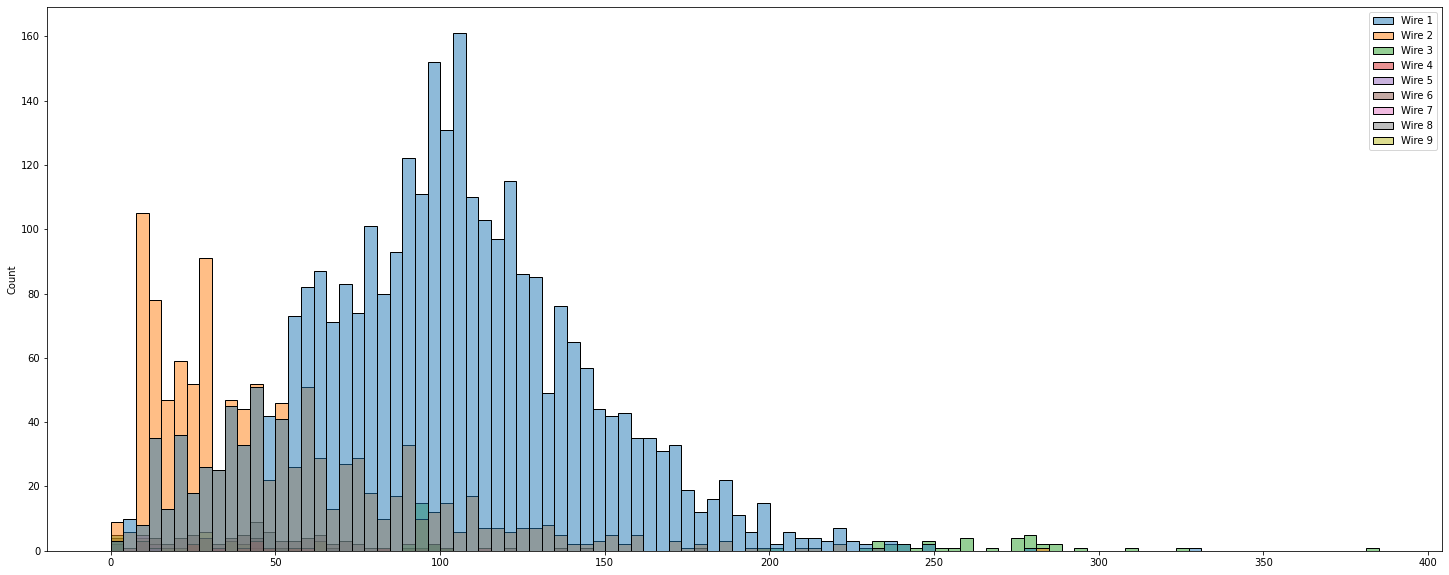

In [33]:
plt.figure(figsize=(25, 10))
sns.histplot(data_wire, bins=100)

<AxesSubplot:xlabel='Wire 3'>

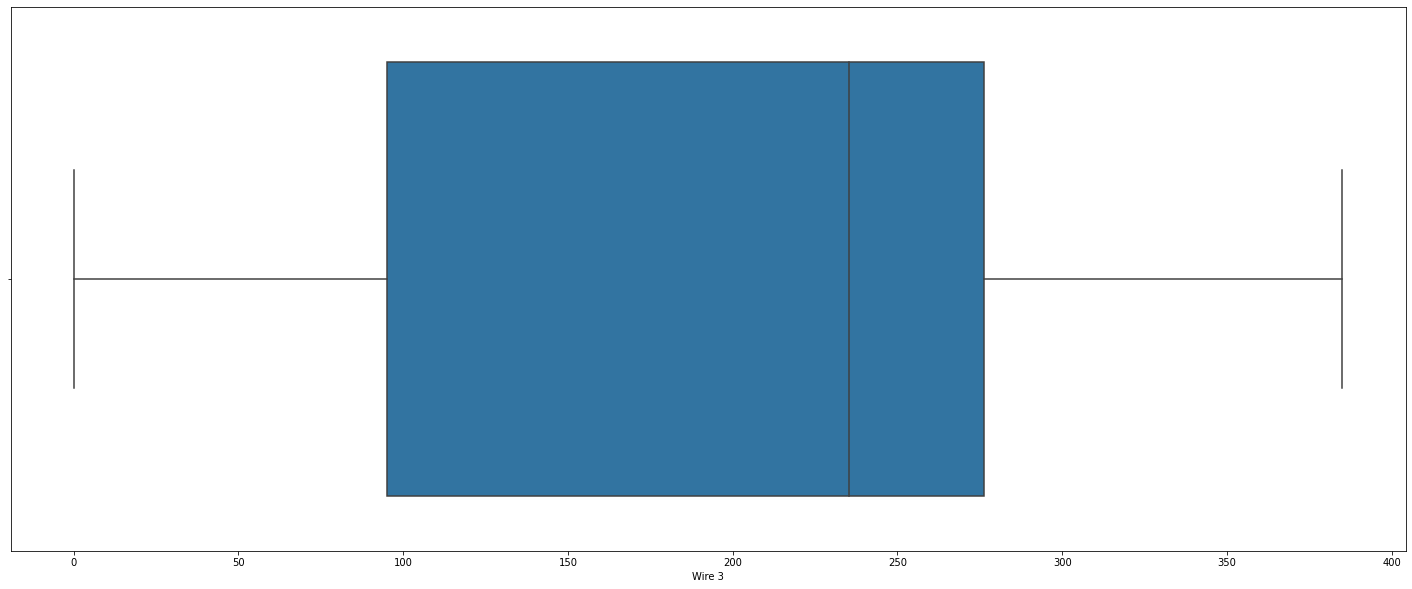

In [34]:
plt.figure(figsize=(25, 10))
sns.boxplot(data_wire['Wire 3'])

In [35]:
data_wire_time.info()
display(data_wire_time.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Wire 1  3055 non-null   datetime64[ns]
 1   Wire 2  1079 non-null   datetime64[ns]
 2   Wire 3  63 non-null     datetime64[ns]
 3   Wire 4  14 non-null     datetime64[ns]
 4   Wire 5  1 non-null      datetime64[ns]
 5   Wire 6  73 non-null     datetime64[ns]
 6   Wire 7  11 non-null     datetime64[ns]
 7   Wire 8  19 non-null     datetime64[ns]
 8   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9)
memory usage: 240.7 KB


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [36]:
print(f'Number of explicit duplicates: {data_gas.duplicated().sum()}')

Number of explicit duplicates: 0


In [37]:
data_wire_time.index.value_counts().count()

3081

##### Вывод

- Данные о проволочных материалах неоднородны;


- Недостаток - пропуски при отсутствии соответствующего колонке проволочного материала в текущей партии;
- Недостаток - названия столбцов простым текстом через пробел;
- Недостаток - данные о времени записаны как строковые, требуется изменение типа данных.

#### Вывод по обзору данных

По итогам предварительного обзора данных выявлены многочисленные замечания, которые можно разбить на следующие категории:
- представление данных - названия колонок;
- пропуски в данных;
- аномальные значения в данных;
- не соответствующие назначению типы данных;
- разное количество уникальных значений 'key' в датасетах.
    
Работа с данными недостатками будет осуществлена на этапе очистки и подготовки данных.

### План работы и вопросы

**План работы**

1. Загрузка и изучение данных. 
 - Обзор и визуализация.
 - Составление списков предварительных замечаний.
 
 
2. Очистка данных.
 - Работа с предварительными замечаниями.
 
 
3. Подготовка признаков.
 - Подготовка сводной таблицы.
 - Выделение тестовой выборки и целевого признака.
 
 
4. Выбор типа решения: модели ML, нейросеть либо оба варианта.


5. Сравнение результатов применения моделей через оценку качества кросс-валидацией.


6. Проверка качества итоговой модели.
 - Проверка на тестовой выборке. 
 - Проверка на адекватность средним и медианными значениями.
 
 
7. Общий вывод.

**Вопросы**
- Рекомендованный подход. Классические алгоритмы ML, или нейросети?
- `data_temp` - какой целевой признак? Температура на каждом этапе, или конечная?
- Рекомендованная метрика качества - RMSE?
- Какое значение метрики необходимо заказчику?

- Где/будет ли описание данных датасетов? Например не ясна значимость разделения колонок в bulk и wire.
- `data_gas` - единица измерения?

## Предобработка данных

data_bulk and data_bulk_time

- Недостаток - пропуски при отсутствии соответствующей колонке примеси в текущей партии;
- Недостаток - в колонке Bulk 12 присутствует выброс значительно превосходящий остальные значения;
- Недостаток - названия столбцов простым текстом через пробел;
- Недостаток - данные о времени записаны как строковые, требуется изменение типа данных.

data_gas

- Недостаток - в колонке Газ 1 присутствует выброс значительно превосходящий остальные значения;
- Недостаток - название столбца простым текстом через пробел.

data_temp

- Недостаток - названия столбцов на кириллице, простым текстом;
- Недостаток - пропуски в колонке Температура;
- Недостаток - в колонке Температура присутствует выброс значительно ниже остальных значений. Температура плавления железа 1539 градусов цельсия, температуры плавления сталей начинаются примерно от 1300 градусов цельсия;
- Недостаток - данные о времени записаны как строковые, требуется изменение типа данных;
- Недостаток - данные о темперутуре записаны как тип с плавающей запятой, но представлены целочисленными значениями, требуется изменение типа данных.

data_wire and data_wire_time

- Недостаток - пропуски при отсутствии соответствующего колонке проволочного материала в текущей партии;
- Недостаток - названия столбцов простым текстом через пробел;
- Недостаток - данные о времени записаны как строковые, требуется изменение типа данных.


### Работа с предварительными замечаниями

Ретроактивно внесены следующие изменения на стадии загрузки данных:
- Колонка `key` переведена в индекс для всех датастов;
- Для датасетов `data_arc`, `data_bulk_time`, `data_temp`, `data_wire_time` использован параметр parse_dates.

#### data_arc

In [38]:
# getting a list of column names and converting them to snake_case
data_arc.columns

Index(['Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность',
       'Реактивная мощность'],
      dtype='object')

In [39]:
data_arc.columns = ['heating_start', 'heating_end',
                    'active_power', 'reactive_power']

data_arc.columns

Index(['heating_start', 'heating_end', 'active_power', 'reactive_power'], dtype='object')

In [40]:
# getting rid of anomalous valie
data_arc = data_arc.query('reactive_power >= 0')

data_arc.reactive_power.min()

0.0208063126

#### data_bulk and data_bulk_time

In [41]:
display(data_bulk.columns)

data_bulk_time.columns

Index(['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7',
       'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13',
       'Bulk 14', 'Bulk 15'],
      dtype='object')

Index(['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7',
       'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13',
       'Bulk 14', 'Bulk 15'],
      dtype='object')

In [42]:
data_bulk.columns = [
    'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5',
    'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10',
    'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15'
]
data_bulk_time.columns = [
    'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5',
    'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10',
    'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15'
]

data_bulk.columns

Index(['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13',
       'bulk_14', 'bulk_15'],
      dtype='object')

In [43]:
data_bulk.fillna(0, inplace=True)

data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bulk_1   3129 non-null   float64
 1   bulk_2   3129 non-null   float64
 2   bulk_3   3129 non-null   float64
 3   bulk_4   3129 non-null   float64
 4   bulk_5   3129 non-null   float64
 5   bulk_6   3129 non-null   float64
 6   bulk_7   3129 non-null   float64
 7   bulk_8   3129 non-null   float64
 8   bulk_9   3129 non-null   float64
 9   bulk_10  3129 non-null   float64
 10  bulk_11  3129 non-null   float64
 11  bulk_12  3129 non-null   float64
 12  bulk_13  3129 non-null   float64
 13  bulk_14  3129 non-null   float64
 14  bulk_15  3129 non-null   float64
dtypes: float64(15)
memory usage: 391.1 KB


In [44]:
data_bulk = data_bulk.astype(int)

data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   bulk_1   3129 non-null   int32
 1   bulk_2   3129 non-null   int32
 2   bulk_3   3129 non-null   int32
 3   bulk_4   3129 non-null   int32
 4   bulk_5   3129 non-null   int32
 5   bulk_6   3129 non-null   int32
 6   bulk_7   3129 non-null   int32
 7   bulk_8   3129 non-null   int32
 8   bulk_9   3129 non-null   int32
 9   bulk_10  3129 non-null   int32
 10  bulk_11  3129 non-null   int32
 11  bulk_12  3129 non-null   int32
 12  bulk_13  3129 non-null   int32
 13  bulk_14  3129 non-null   int32
 14  bulk_15  3129 non-null   int32
dtypes: int32(15)
memory usage: 207.8 KB


In [45]:
data_bulk = data_bulk.query('bulk_12 <= 1000')

data_bulk.bulk_12.max()

853

#### data_gas

In [46]:
data_gas.columns = ['gas']

data_gas.columns

Index(['gas'], dtype='object')

In [47]:
data_gas = data_gas.query('gas <= 70')

data_gas.gas.max()

60.935689163800006

#### data_temp

In [48]:
data_temp.columns = ['meas_time', 'temp']

data_temp.columns

Index(['meas_time', 'temp'], dtype='object')

In [49]:
# Significant amount of blanks in 'temp'.
# Filling them will dilute features with synthetic data.
# Dropping blanks instead.
data_temp.dropna(inplace=True)

In [50]:
data_temp.temp = data_temp.temp.astype(int)

data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   meas_time  13006 non-null  datetime64[ns]
 1   temp       13006 non-null  int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 254.0 KB


In [51]:
data_temp = data_temp.query('temp >= 1300')

data_temp.temp.min()

1383

#### data_wire and data_wire_time

In [52]:
display(data_wire.columns)

data_wire_time.columns

Index(['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7',
       'Wire 8', 'Wire 9'],
      dtype='object')

Index(['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7',
       'Wire 8', 'Wire 9'],
      dtype='object')

In [53]:
data_wire.columns = [
    'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5',
    'wire_6', 'wire_7', 'wire_8', 'wire_9'
]
data_wire_time.columns = [
    'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5',
    'wire_6', 'wire_7', 'wire_8', 'wire_9'
]

data_wire.columns

Index(['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7',
       'wire_8', 'wire_9'],
      dtype='object')

In [54]:
data_wire.fillna(0, inplace=True)

data_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wire_1  3081 non-null   float64
 1   wire_2  3081 non-null   float64
 2   wire_3  3081 non-null   float64
 3   wire_4  3081 non-null   float64
 4   wire_5  3081 non-null   float64
 5   wire_6  3081 non-null   float64
 6   wire_7  3081 non-null   float64
 7   wire_8  3081 non-null   float64
 8   wire_9  3081 non-null   float64
dtypes: float64(9)
memory usage: 240.7 KB


#### Вывод

Предварительные замечания устранены. Данные готовы к дальнейшей обработке.

### Подготовка сводной таблицы

Для подготовки сводной таблицы необходимо выделить признаки из имеющихся данных, после чего произвести объединение по индексу (номеру партии). Считаю необходимым организацию признаков таким образом чтобы каждому номеру партии соответствовала одна строка.

#### data_arc

In [55]:
# Checking corr between active and reactive powers, and time spent on heating.
data_arc['heating_time'] = (
    data_arc['heating_end'] - data_arc['heating_start']
) / pd.Timedelta(minutes=1)

data_arc.corr()

,active_power,reactive_power,heating_time
active_power,1.000000,0.963182,0.974129
reactive_power,0.963182,1.000000,0.971269
heating_time,0.974129,0.971269,1.000000


Ожидаемо высокая корреляция между активной и реактивной мощностью, а также продолжительностью нагрева. Из-за высокой корреляции не имеет смысла их использование как отдельных параметров. Возможно использовать лишь активную мощность, либо сумму значений мощности и затраченного времени. Значения должны быть сгруппированы по номеру партии. Также считаю неоходимым добавить и проверить на корреляцию колонку содержащую количество циклов нагрева внутри партии.

In [56]:
data_arc['heating'] = data_arc[
    ['active_power', 'reactive_power', 'heating_time']
].sum(axis=1)

In [57]:
cycles = data_arc['heating'].groupby('key').count()

cycles

key
1       5
2       4
3       5
4       4
5       4
       ..
3237    5
3238    3
3239    8
3240    5
3241    5
Name: heating, Length: 3214, dtype: int64

In [58]:
heating = data_arc['heating'].groupby('key').sum()

heating

key
1       26.361388
2       18.567377
3       15.041625
4       17.619548
5       20.083149
          ...    
3237    21.910926
3238    12.887711
3239    28.045038
3240    19.450683
3241    15.150979
Name: heating, Length: 3214, dtype: float64

In [59]:
final_arc = pd.concat([heating, cycles], axis=1)
final_arc.columns = ['heating', 'cycles']

final_arc

,heating,cycles
key,,
1,26.361388,5
2,18.567377,4
3,15.041625,5
4,17.619548,4
5,20.083149,4
...,...,...
3237,21.910926,5
3238,12.887711,3
3239,28.045038,8


In [60]:
final_arc.corr()

,heating,cycles
heating,1.000000,0.768056
cycles,0.768056,1.000000


Высокая, но приемлемая корреляция. Получены признаки датасета `data_arc`.

#### data_bulk and data_bulk_time

На данный момент не вижу способа использовать `data_bulk_time` в качестве признака. Колонки `data_bulk` будут проверены суммой, при обнаружении колонки содержащей лишь нули такая колонка будет удалены. В остальном `data_bulk` не нуждается в дальнейшей обработке.

In [61]:
# checking if there is columns with all zeroes
data_bulk.sum()

bulk_1       9704
bulk_2       5567
bulk_3     147714
bulk_4     105798
bulk_5       8241
bulk_6      68501
bulk_7       7234
bulk_8         49
bulk_9       1450
bulk_10     14658
bulk_11     13597
bulk_12    636305
bulk_13      3260
bulk_14    477183
bulk_15    360834
dtype: int64

In [62]:
final_bulk = data_bulk

#### data_gas

Датасет `data_gas` содержит одну колонку с релевантными данными и готов к использованию в качестве признака.

In [63]:
final_gas = data_gas

#### data_temp

Так как в качестве целевого признака нас интересует финальный замер температуры, то его следует выделить в отдельную колонку. Следовательно имеют значение лишь партии с более чем одним замером температуры. Проверю датасет на минимальное количество замеров через подсчет уникальных значений номера партии.

In [64]:
data_temp.index.value_counts().min()

1

Минимальное количество замеров в партии - 1. Вероятно, предоставлены неполные данные. Такие партии бесполезны для решения поставленной задачи, их следует отбросить.  
Также возможно сравнение времени послледнего замера в партии со временем окончания последнего прогрева в партии. Так как известно о возможной задержке срабатывания датчиков, то можно задать погрешность при которой разница между временем окончания прогрева и замера не будет считаться решающей. Для перестраховки возьму разницу в одну минуту.

In [65]:
# Cycle finds a difference in time between last measurement and end of heating.
# Negative difference means last measurement has occured before end of heating.
# Then cycle finds keys with only one measurement.

discard = []

for key in list(data_temp.index.unique()):
    if ((((data_temp[data_temp.index == key]['meas_time'].max() -
           data_arc[data_arc.index == key]['heating_end'].max()) /
          pd.Timedelta(minutes=1)) < -1) or
        (data_temp[data_temp.index == key]['meas_time'].max() ==
         data_temp[data_temp.index == key]['meas_time'].min())):
        discard.append(key)

len(discard)

855

In [66]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13001 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   meas_time  13001 non-null  datetime64[ns]
 1   temp       13001 non-null  int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 770.0 KB


In [67]:
data_temp = data_temp.query('key not in @discard')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11750 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   meas_time  11750 non-null  datetime64[ns]
 1   temp       11750 non-null  int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 229.5 KB


Сами по себе замеры не оказывают влияния на температуру. Оставлю только стартовую температуру металла при первом измерении в ковше, и последний замер.

In [68]:
# Using head and tail functions to split first and last measurement in key
final_temp = data_temp.groupby('key')
final_temp = pd.merge(
    final_temp.head(1), final_temp.tail(1), on='key'
)
final_temp.head(10)

,meas_time_x,temp_x,meas_time_y,temp_y
key,,,,
1,2019-05-03 11:16:18,1571,2019-05-03 11:30:39,1613
2,2019-05-03 11:37:27,1581,2019-05-03 11:59:12,1602
3,2019-05-03 12:13:17,1596,2019-05-03 12:34:57,1599
4,2019-05-03 12:52:57,1601,2019-05-03 12:59:25,1625
5,2019-05-03 13:23:19,1576,2019-05-03 13:36:01,1602
6,2019-05-03 13:49:24,1543,2019-05-03 14:12:29,1596
7,2019-05-03 14:19:43,1586,2019-05-03 14:42:37,1599
8,2019-05-03 15:07:18,1577,2019-05-03 15:22:52,1598
9,2019-05-03 15:37:03,1587,2019-05-03 16:01:16,1592


In [69]:
final_temp = final_temp[['temp_x', 'temp_y']]
final_temp.columns = ['first_temp', 'last_temp']
final_temp.head()

,first_temp,last_temp
key,,
1,1571,1613
2,1581,1602
3,1596,1599
4,1601,1625
5,1576,1602


Получены признаки датасета `data_temp`, включая целевой признак.

#### data_wire and data_wire_time

На данный момент не вижу способа использовать `data_wire_time` в качестве признака. Колонки `data_wire` будут проверены суммой, при обнаружении колонки содержащей лишь нули такая колонка будет удалены. В остальном `data_wire` не нуждается в дальнейшей обработке.

In [70]:
# checking if there is columns with all zeroes
data_wire.sum()

wire_1    308236.830606
wire_2     54572.931650
wire_3     11937.408916
wire_4       804.199781
wire_5        15.132000
wire_6      3505.239099
wire_7       110.429080
wire_8      1018.878666
wire_9       990.516814
dtype: float64

In [71]:
# data_bulk['total_bulk'] = data_bulk.sum(axis=1)
final_wire = data_wire

#### Объединение признаков

In [72]:
final_frames = [final_temp, final_arc, final_bulk, final_gas, final_wire]

In [73]:
data_final = reduce(lambda left, right: pd.merge(
    left, right, on=['key'], how='outer'
), final_frames)
data_final.dropna(inplace=True)
data_final.info()
data_final.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2225 entries, 1 to 2499
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   first_temp  2225 non-null   float64
 1   last_temp   2225 non-null   float64
 2   heating     2225 non-null   float64
 3   cycles      2225 non-null   float64
 4   bulk_1      2225 non-null   float64
 5   bulk_2      2225 non-null   float64
 6   bulk_3      2225 non-null   float64
 7   bulk_4      2225 non-null   float64
 8   bulk_5      2225 non-null   float64
 9   bulk_6      2225 non-null   float64
 10  bulk_7      2225 non-null   float64
 11  bulk_8      2225 non-null   float64
 12  bulk_9      2225 non-null   float64
 13  bulk_10     2225 non-null   float64
 14  bulk_11     2225 non-null   float64
 15  bulk_12     2225 non-null   float64
 16  bulk_13     2225 non-null   float64
 17  bulk_14     2225 non-null   float64
 18  bulk_15     2225 non-null   float64
 19  gas         2225 non-null  

,first_temp,last_temp,heating,cycles,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,26.361388,5.0,0.0,0.0,0.0,43.0,0.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1581.0,1602.0,18.567377,4.0,0.0,0.0,0.0,73.0,0.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1596.0,1599.0,15.041625,5.0,0.0,0.0,0.0,34.0,0.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1601.0,1625.0,17.619548,4.0,0.0,0.0,0.0,81.0,0.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1576.0,1602.0,20.083149,4.0,0.0,0.0,0.0,78.0,0.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
data_final.dropna(inplace=True, axis=1)

In [75]:
# Getting correlation matrix.
# Getting rid of diagonal and doubles
# Checking for high correlation
corr_matrix = data_final.corr().abs()
corr_matrix = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)
)
display(corr_matrix)

to_drop = [
    column for column in corr_matrix.columns if any(corr_matrix[column] > 0.90)
]
to_drop

,first_temp,last_temp,heating,cycles,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
first_temp,NaN,0.297766,0.400594,0.177035,0.075779,0.144692,0.113173,0.164850,0.080320,0.135977,...,0.036770,0.264393,0.107193,0.003747,0.077760,NaN,0.020965,0.053973,0.030689,0.004746
last_temp,NaN,NaN,0.280400,0.180764,0.093708,0.084583,0.040560,0.190876,0.029603,0.195169,...,0.052239,0.326279,0.220468,0.049176,0.163395,NaN,0.086421,0.140276,0.011382,0.027503
heating,NaN,NaN,NaN,0.791506,0.069103,0.040635,0.095375,0.031562,0.014243,0.168272,...,0.375093,0.058039,0.045433,0.035365,0.058698,NaN,0.048263,0.028615,0.020876,0.012320
cycles,NaN,NaN,NaN,NaN,0.068492,0.096372,0.113739,0.008042,0.078670,0.164314,...,0.399972,0.144129,0.067453,0.058448,0.117227,NaN,0.056477,0.075795,0.046061,0.027154
bulk_1,NaN,NaN,NaN,NaN,NaN,0.239913,0.018785,0.038866,0.064882,0.001764,...,0.173864,0.020244,0.046064,0.022037,0.156257,NaN,0.158871,0.089094,0.020581,0.013435
bulk_2,NaN,NaN,NaN,NaN,NaN,NaN,0.048470,0.042907,0.360055,0.031209,...,0.227900,0.174276,0.040227,0.222897,0.699277,NaN,0.558735,0.431695,0.005521,0.006984
bulk_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.292865,0.008498,0.065773,...,0.058046,0.043738,0.091787,0.004264,0.041892,NaN,0.005656,0.020102,0.003935,0.005946
bulk_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030685,0.251789,...,0.009351,0.295242,0.273253,0.038814,0.036225,NaN,0.010269,0.035176,0.008972,0.057093
bulk_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.023448,...,0.091055,0.012621,0.014479,0.070323,0.262519,NaN,0.204325,0.172030,0.008730,0.011044
bulk_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.153196,0.239468,0.204774,0.048429,0.026974,NaN,0.021738,0.012944,0.029602,0.013171


['wire_8']

In [76]:
# getting rid of high corr columns
data_final.drop(to_drop, axis=1, inplace=True)

In [77]:
# 'wire_5' had only one value
# checking if that value got dropepd in the end
data_final.wire_5.sum()

0.0

In [78]:
# dropping 'wire_5' as it's only zeros now
data_final.drop('wire_5', axis=1, inplace=True)

###  Выделение тестовой выборки и целевого признака

В соответствии с условием задачи, соотншение обучающей и тестовой выборки 3 к 1, в связи с чем выделяю 25% сводной таблицы как тестовую выборку.

In [79]:
features = data_final.drop('last_temp', axis=1)
target = data_final['last_temp']

In [80]:
features_train, features_test, target_train, target_test = train_test_split(
                                                            features,
                                                            target,
                                                            test_size=0.25,
                                                            random_state=STATE)

### Вывод

Произведена предварительная обработка данных. В результате предварительной обработки получена сводная таблица признаков содержащая 2225 строк. Категориальные признаки отсутствуют, их кодирование не требуется. Данные разбиты на обучающую и тестовую выборки и готовы к обработке алгоритмами машинного обучения.

## Обучение и сравнение моделей

### Выбор типа решения

Так как по итогам обработки данных получен датасет небольшого объема, то усложнение задачи не требуется. Классических алгоритмов ML будет достаточно для получения необходимого результата. Применение нейронных сетей считаю излишним.

Для обучения и сравнения использую следующие модели: `LinearRegression`, `DecisionTreeRegressor`, `CatBoostRegressor`, `LGBMRegressor`

### Обучение и сравнение результатов применения моделей

### LinearRegression

In [81]:
%%time

model_lr = LinearRegression()

model_lr.fit(features_train, target_train)

CPU times: total: 0 ns
Wall time: 2.99 ms


LinearRegression()

In [82]:
nmae_lr = cross_val_score(
    model_lr, features_train, target_train,
    cv=CV, scoring='neg_median_absolute_error'
)

lr_score_1 = -nmae_lr.mean()
print(nmae_lr)
print('Значение MAE для Линейной Регрессии:', lr_score_1)

[-5.16062257 -4.77844672 -4.44018928 -5.41734796 -4.71872721]
Значение MAE для Линейной Регрессии: 4.903066747530533


In [83]:
# normalizing data for LinearRegression
scaler = StandardScaler().fit(features_train)
scaled_features_train = scaler.transform(features_train)
scaled_features_test = scaler.transform(features_test)

In [84]:
%%time

model_lr = LinearRegression()

model_lr.fit(scaled_features_train, target_train)

CPU times: total: 0 ns
Wall time: 1.99 ms


LinearRegression()

In [85]:
nmae_lr = cross_val_score(
    model_lr, scaled_features_train, target_train,
    cv=CV, scoring='neg_median_absolute_error'
)

lr_score_2 = -nmae_lr.mean()
print(nmae_lr)
print('Значение MAE для Линейной Регрессии:', lr_score_2)

[-5.16062257 -4.77844672 -4.44018928 -5.41734796 -4.71872721]
Значение MAE для Линейной Регрессии: 4.9030667475305565


In [86]:
lr_score = max(lr_score_1, lr_score_2)
lr_score

4.9030667475305565

### DecisionTreeRegressor

In [87]:
%%time

dtr = DecisionTreeRegressor()

params_dtr = [{
    'max_depth': range(2, 10),
    'min_samples_leaf': [1, 2, 3, 4, 5],
    "min_weight_fraction_leaf":[0.0, 0.1, 0.25],
    'random_state':[STATE]
}]

model_dtr = GridSearchCV(dtr,
                      param_grid=params_dtr,
                      cv=CV,
                      scoring='neg_median_absolute_error')

model_dtr.fit(features_train, target_train)

CPU times: total: 2.89 s
Wall time: 2.89 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': range(2, 10),
                          'min_samples_leaf': [1, 2, 3, 4, 5],
                          'min_weight_fraction_leaf': [0.0, 0.1, 0.25],
                          'random_state': [171022]}],
             scoring='neg_median_absolute_error')

In [88]:
dtr_score =  -model_dtr.best_score_
print('Лучшее значение MAE для DecisionTreeRegressor:',
      dtr_score)
'Оптимальные параметры модели:', model_dtr.best_params_

Лучшее значение MAE для DecisionTreeRegressor: 5.085382590763606


('Оптимальные параметры модели:',
 {'max_depth': 6,
  'min_samples_leaf': 1,
  'min_weight_fraction_leaf': 0.0,
  'random_state': 171022})

### LGBMRegressor

In [89]:
%%time

lgbm = LGBMRegressor(random_state=STATE)

params_lgbm = [{
    'num_leaves': [10, 25, 50, 75],
    'learning_rate': [0.01, 0.03, 0.1],
    'n_estimators': [50, 100, 200, 500]
}]

model_lgbm = GridSearchCV(lgbm,
                      param_grid=params_lgbm,
                      cv=CV,
                      scoring='neg_median_absolute_error')

model_lgbm.fit(features_train, target_train)

CPU times: total: 6min 58s
Wall time: 27.3 s


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=171022),
             param_grid=[{'learning_rate': [0.01, 0.03, 0.1],
                          'n_estimators': [50, 100, 200, 500],
                          'num_leaves': [10, 25, 50, 75]}],
             scoring='neg_median_absolute_error')

In [90]:
lgbm_score = -model_lgbm.best_score_
print('Лучшее значение MAE для LGBMRegressor:',
      lgbm_score)
'Оптимальные параметры модели:', model_lgbm.best_params_

Лучшее значение MAE для LGBMRegressor: 4.592509462064982


('Оптимальные параметры модели:',
 {'learning_rate': 0.03, 'n_estimators': 100, 'num_leaves': 75})

### CatBoostRegressor

In [91]:
%%time

cb = CatBoostRegressor(random_state=STATE)

params_cb = {'depth': range(6, 11),
             'learning_rate' : [0.05, 0.1, 0.15],
              'iterations'    : [50, 100, 150]}

model_cb = GridSearchCV(cb,
                      param_grid=params_cb,
                      cv=CV,
                      scoring='neg_median_absolute_error')

model_cb.fit(features_train, target_train)

0:	learn: 11.0269809	total: 144ms	remaining: 7.07s
1:	learn: 10.8917677	total: 148ms	remaining: 3.54s
2:	learn: 10.7537902	total: 149ms	remaining: 2.33s
3:	learn: 10.6285636	total: 150ms	remaining: 1.72s
4:	learn: 10.5013878	total: 151ms	remaining: 1.36s
5:	learn: 10.3817758	total: 152ms	remaining: 1.11s
6:	learn: 10.2642394	total: 153ms	remaining: 941ms
7:	learn: 10.1670757	total: 154ms	remaining: 810ms
8:	learn: 10.0551811	total: 155ms	remaining: 707ms
9:	learn: 9.9548517	total: 157ms	remaining: 626ms
10:	learn: 9.8592511	total: 158ms	remaining: 561ms
11:	learn: 9.7570172	total: 160ms	remaining: 506ms
12:	learn: 9.6666540	total: 161ms	remaining: 458ms
13:	learn: 9.5898281	total: 163ms	remaining: 418ms
14:	learn: 9.5106964	total: 164ms	remaining: 383ms
15:	learn: 9.4368124	total: 165ms	remaining: 351ms
16:	learn: 9.3600022	total: 166ms	remaining: 323ms
17:	learn: 9.2946591	total: 168ms	remaining: 298ms
18:	learn: 9.2413286	total: 169ms	remaining: 275ms
19:	learn: 9.1805810	total: 170m

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001FB8F4D0490>,
             param_grid={'depth': range(6, 11), 'iterations': [50, 100, 150],
                         'learning_rate': [0.05, 0.1, 0.15]},
             scoring='neg_median_absolute_error')

In [92]:
cb_score = -model_cb.best_score_
print('Лучшее значение MAE для CatBoostRegressor:',
      cb_score)
'Оптимальные параметры модели:', model_cb.best_params_

Лучшее значение MAE для CatBoostRegressor: 4.50448648368415


('Оптимальные параметры модели:',
 {'depth': 7, 'iterations': 100, 'learning_rate': 0.15})

### Вывод

В результате обучения моделей и их сравнения путем пятикратной кросс-валидации, модель `CatBoostRegressor` показала наилучний результат, достигнув метрики MAE = 4.504
Данная модель будет проверена на тестовых данных.

In [93]:
cv_dict = {
    'Model Name': ['LinearRegression',
                   'DecisionTreeRegressor',
                   'LGBMRegressor',
                   'CatBoostRegressor'],
    'Result': [lr_score,
               dtr_score,
               lgbm_score,
               cb_score]
}
cv_comp = pd.DataFrame(cv_dict)
cv_comp['MAE Difference'] = cv_comp['Result'] - cv_comp['Result'].min()
cv_comp

,Model Name,Result,MAE Difference
0,LinearRegression,4.903067,0.398580
1,DecisionTreeRegressor,5.085383,0.580896
2,LGBMRegressor,4.592509,0.088023
3,CatBoostRegressor,4.504486,0.000000


<font color='blue'><b>Комментарий тимлида</b></font><strike>
<br><font color='darkorange'>⚠️ Можно добавить сравнительную таблицу, чтобы легко было увидеть метрики качества.на валидации.</font></strike>

## Проверка качества итоговой модели

Для проверки качества итоговоя модели, модель `CatBoostRegressor` будет переобучена с подобранными гиперпараметрами, и применена для предсказания на тестовых данных без кросс валидации.  
После проверки качества модель будет проверена на адекватность путем сравнения со средними и медианными значениями.

### Проверка на качество

In [94]:
%%time

model_cb = CatBoostRegressor(random_state=STATE, depth=7,
                             iterations=100, learning_rate=0.15)

model_cb.fit(features_train, target_train)

0:	learn: 10.8208563	total: 2.36ms	remaining: 234ms
1:	learn: 10.4252681	total: 4.37ms	remaining: 214ms
2:	learn: 10.0990707	total: 5.98ms	remaining: 193ms
3:	learn: 9.7978795	total: 7.77ms	remaining: 186ms
4:	learn: 9.5603386	total: 9.48ms	remaining: 180ms
5:	learn: 9.3806533	total: 11.1ms	remaining: 174ms
6:	learn: 9.1679134	total: 12.6ms	remaining: 168ms
7:	learn: 8.9570086	total: 14.3ms	remaining: 165ms
8:	learn: 8.8020266	total: 15.8ms	remaining: 160ms
9:	learn: 8.6521695	total: 17.4ms	remaining: 156ms
10:	learn: 8.5849324	total: 18.9ms	remaining: 153ms
11:	learn: 8.4744287	total: 20.5ms	remaining: 150ms
12:	learn: 8.3652378	total: 22ms	remaining: 147ms
13:	learn: 8.2674917	total: 23.5ms	remaining: 145ms
14:	learn: 8.1550954	total: 25.1ms	remaining: 142ms
15:	learn: 8.0758871	total: 26.6ms	remaining: 140ms
16:	learn: 8.0093610	total: 28.2ms	remaining: 138ms
17:	learn: 7.9441411	total: 29.7ms	remaining: 136ms
18:	learn: 7.8594842	total: 31.4ms	remaining: 134ms
19:	learn: 7.8152149	

In [95]:
%%time

cb_predict = model_cb.predict(features_test)

CPU times: total: 0 ns
Wall time: 3.99 ms


In [96]:
cb_MAE = mean_absolute_error(target_test, cb_predict)
cb_MAE

5.990236953794781

<font color='blue'><b>Комментарий тимлида</b></font>
<br><font color='green'> ✔️ Модель выбрана.</font>

### Проверка на адекватнсть

In [97]:
pred_median = np.ones(target_test.shape) * target_train.median()
print('MAE константы:', mean_absolute_error(target_test, pred_median))

MAE константы: 7.876122082585279


In [98]:
pred_mean = np.ones(target_test.shape) * target_train.mean()
print('MAE константы:', mean_absolute_error(target_test, pred_mean))

MAE константы: 7.889138240574506


### Вывод

В резальтуте проверки на качество на тестовой выборке модель `CatBoostRegressor` показала метрику MAE = 5.990, что соотвествует погрешности предсказания в шесть градусов Цельсия. Данный показатель удовлетворяет требования заказчика.  
При проверке на адекватность наилучший результат показала медианная модель, с MAE = 7.876, что также удовлетворяет требованиям заказчика, но в меньшей мере, с погрешностью почти на два градуса Цельсия выше чем при использовании модели `CatBoostRegressor`.

## Общий вывод

По итогам проверки достигнуто требуемое заказчиком значение метрики MAE модели. Лучшая модель - `CatBoostRegressor`. Достигнута MAE = 5.990

Гиперпарамтеры лучший модели подобраны путем использования техникпи GridSearchCV с пятикратной кросс-валидацией.  
Подобраны следующие гиперпараметры - `depth`: 7, `iterations`: 100, `learning_rate`: 0.15
Результат зафиксирован константой `STATE` = 171022

Ниже приводится сравнительный график важности признаков, а также список с чисовым выражением важности признаков в процентах. По важности с большим лидируют признаки `heating` и `first_temp`.

<AxesSubplot:>

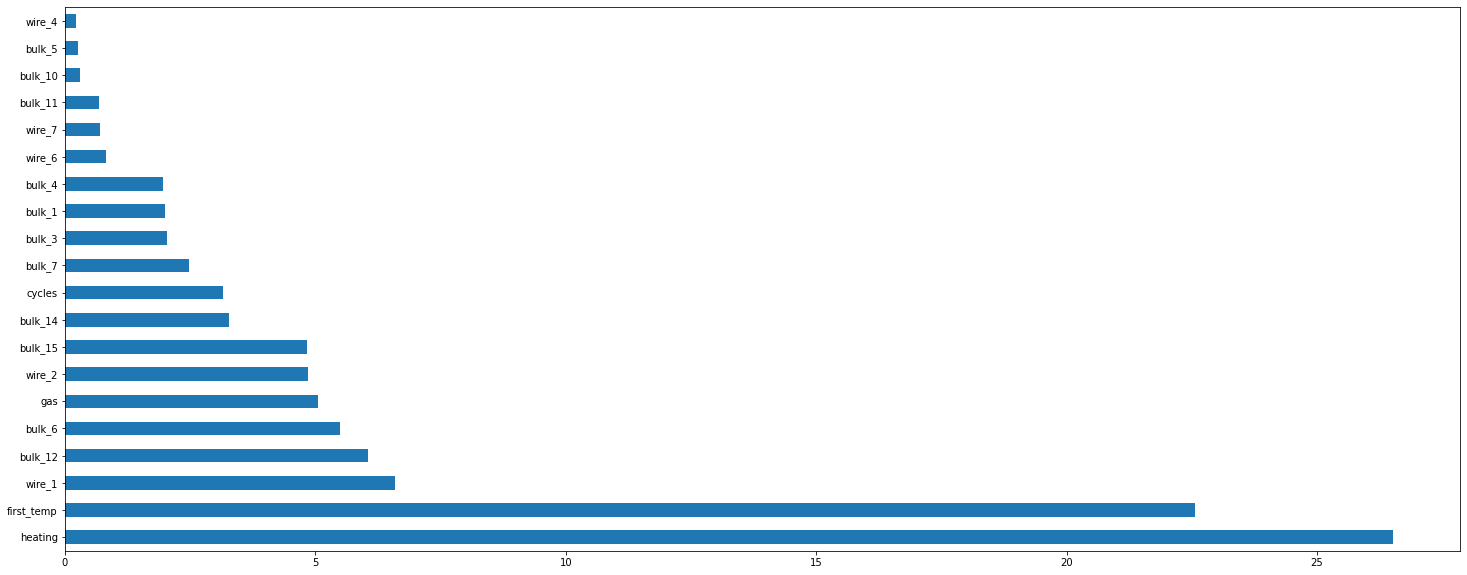

In [99]:
feat_importances = pd.Series(
    model_cb.feature_importances_, index=features.columns
)
feat_importances.nlargest(20).plot(kind='barh', figsize=(25, 10))

In [100]:
feat_importances.sort_values(ascending=False)

heating       26.524434
first_temp    22.567462
wire_1         6.599726
bulk_12        6.057195
bulk_6         5.499914
gas            5.055805
wire_2         4.851045
bulk_15        4.837585
bulk_14        3.277420
cycles         3.163631
bulk_7         2.477793
bulk_3         2.047011
bulk_1         1.996069
bulk_4         1.962186
wire_6         0.828508
wire_7         0.696636
bulk_11        0.676089
bulk_10        0.303974
bulk_5         0.270089
wire_4         0.219166
wire_3         0.040930
bulk_9         0.026740
bulk_13        0.012118
bulk_2         0.008473
bulk_8         0.000000
wire_9         0.000000
dtype: float64

<font color='blue'><b>Комментарий тимлида</b></font>
<br><font color='green'> ✔️ отличный разбор важности.</font>

### Инструкция по подготовке признаков

Датасеты `data_bulk_time` и `data_wire_time` не требуются для обучения модели.

&nbsp; &nbsp; **Шаг 1.** Загрузить датасеты `data_arc`, `data_bulk`, `data_gas`, `data_temp` и `data_wire`.

- Первая колонка `key` каждего датасета используется в качестве инекса - `index_col=[0]`;
- Датасет `data_arc` содержит данные о времени, при загрузке используйте - `parse_dates=[1, 2]`;
- Датасет `data_temp` содержит данные о времени, при загрузке используйте - `parse_dates=[1]`.

&nbsp; &nbsp; **Шаг 2.** Предстваление данных в едином стандарте.

- Дальнейшие шаги удобнее осуществлять, приведя названия колонок к `snake_case`.

&nbsp; &nbsp; **Шаг 3.** Поиск и устранение аномальных значений.

- В приведенных данных не должно быть отрицательных значений;
- Для определения иных аномальных значений используйте график `boxplot`;
- Для решения по аномальным значениям температуры лучше обратиться к технологу.

&nbsp; &nbsp; **Шаг 4.** Пропущенные значения в датасетах `data_bulk` и `data_wire` заполняются нулями.

&nbsp; &nbsp; **Шаг 5.** На основе датасета `data_arc` получаем признак `heating` путем сложения активной мощности, реактивной мощности и времени нагревания.

&nbsp; &nbsp; **Шаг 6.** На основе датасета `data_temp` получаем признаки `first_temp` и `last_temp` путем выделения первого и последнего замера в партии.

- Необходимо исключить партии с одним замером;
- Необходимо исключить партии в которых нагрев околчился позже минуты после последнего замера, где минута, либо иной отрезок времени определенный технологом, это возможная задержка времени срабатывания датчика.

&nbsp; &nbsp; **Шаг 7.** Производим внешнее объединение датасетов `data_arc`, `data_bulk`, `data_gas`, `data_temp` и `data_wire` по индексу `key`, получаем датасет `data_final`.

- После объединения используйте dropna чтоббы избавиться от партий с неполными данными;
- Внимательно проверьте признаки из `data_bulk` и `data_wire` после предыдущего действия, избавтесь от признаков с лишь нулевыми значениями;
- Проверьте мультиколлинарность полученных признаков и избавьтесь от признаков, избавьтесь от признаков со слишком высокоий линейно зависимостью (свыше 0.9).

&nbsp; &nbsp; **Шаг 8.** Выделите `last_temp` в целевой признак.

&nbsp; &nbsp; **Шаг 9.** Разбейте признаки на обучающую и тестовую выборки в соотношении 3:1.

- Признаки подготовлены к обучению модели.

### Ответы на финальные вопросы

**Какие пункты плана были выполнены, а какие — нет (поясните почему)?**

План выполнен в полном объеме.

План:
```
1. Загрузка и изучение данных. 
 - Обзор и визуализация.
 - Составление списков предварительных замечаний.
 
 2. Очистка данных.
 - Работа с предварительными замечаниями.
 
 3. Подготовка признаков.
 - Подготовка сводной таблицы.
 - Выделение тестовой выборки и целевого признака.
 
 4. Выбор типа решения: модели ML, нейросеть либо оба варианта.

5. Сравнение результатов применения моделей через оценку качества кросс-валидацией.

6. Проверка качества итоговой модели.
 - Проверка на тестовой выборке. 
 - Проверка на адекватность средним и медианными значениями.
 
 7. Общий вывод.
```

**Какие трудности возникли и как вы их преодолели?**

Основная трудность, как всегда, время. Преодолел свокойным вечерним прогрессом и кофе.  
Приходилось поднимать код прошлых проектот, так какз а несколько последних спринтов уже успели подзабыться некоторые основы нужные в предобработке данных, но на то они и основы чтобы их можно было быстро вспомнить.  
Сложно было вникнуть в задание, но эта сложность создана намеренно, тут помогли вопросы и вебинар.  
В общем, никаких сложностей сверх обычных.

**Какие ключевые шаги в решении задачи выделили?**

Все согласно плану. Сверх того - коммуникация. Уточнение задания, вопросы. Очень важный шаг.

**Какая ваша итоговая модель и какое у неё качество?**

`CatBoostRegressor`. MAE = 5.990
Уверен что можно намного лучше. Наверное не стоило вообще использовать реактивную мощность, даже в составе суммарного признака.